In [1]:

import numpy as np # used for handling numbers
import pandas as pd # used for handling the dataset
from sklearn.impute import SimpleImputer # used for handling missing data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder # used for encoding categorical data
from sklearn.model_selection import train_test_split # used for splitting training and testing data
from sklearn.preprocessing import StandardScaler # used for feature scaling



import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from sklearn.utils import shuffle



from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error


2023-03-16 10:15:44.990203: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-16 10:15:45.096756: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-16 10:15:45.100340: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-16 10:15:45.100349: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
#reading the dataset
df = pd.read_csv('10_data_trimed_attack_noAttack.csv')

def read_dataset():
    #print
    X = df[df.columns[0:42]].values
    y = df[df.columns[41]]
    
    
    #encode the dependant variable
    Y = one_hot_encode(y)
    print(X.shape)
    print(Y.shape)
    return(X,Y)

#define one-hot-encoder function
def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels, n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

#Read the dataset
X, Y = read_dataset()



(494020, 42)
(494020, 2)


In [3]:
#shufffle the dataset to mix up the rows
X,Y = shuffle(X, Y,random_state = 1)

#dataset into train & test 
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.20, random_state=415)

#shapes of the training and testing
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)


(395216, 42)
(395216, 2)
(98804, 42)
(98804, 2)


In [4]:
#define the important parameters and variables to work with the tensors
initial_learning_rate = 0.3
decay_steps = 10000
decay_rate = 0.96
training_epochs = 500
cost_history = np.empty(shape=[1], dtype=float)
n_dim = X.shape[1]
print("n_dim", n_dim)
n_class = 2
model_path = "model"



n_dim 42


In [5]:
#define the number of hidden layers and number of neurons for each layer
n_hidden_1 = 20
n_hidden_2 = 20
n_hidden_3 = 20

global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step, decay_steps, decay_rate)

x = tf.placeholder(tf.float32, [None, n_dim])
W = tf.Variable(tf.zeros([n_dim, n_class]))
b = tf.Variable(tf.zeros([n_class]))
y_ = tf.placeholder(tf.float32, [None, n_class])

y_


<tf.Tensor 'Placeholder_1:0' shape=(?, 2) dtype=float32>

In [6]:
#define the model

def attack_finder(x, weights, biases):
    
    #RELU activation function
    layer_1 = tf.add(tf.matmul(x, weights["h1"]), biases["b1"])
    layer_1 = tf.nn.relu(layer_1)
    
    #sigmoid activation function
    layer_2 = tf.add(tf.matmul(layer_1, weights["h2"]), biases["b2"])
    layer_2 = tf.nn.sigmoid(layer_2)
     
    #softmax activation function
    layer_3 = tf.add(tf.matmul(layer_2, weights["h3"]), biases["b3"])
    layer_3 = tf.nn.softmax(layer_3)
    
    #outer layer relu activation function
    out_layer = tf.add(tf.matmul(layer_3, weights["out"]), biases["out"])
    out_layer = tf.nn.softmax(out_layer)
    
    return out_layer
    
    


In [7]:
#Define the weights and biases for each layer

weights = {
    "h1" : tf.Variable(tf.truncated_normal([n_dim, n_hidden_1])),
    "h2" : tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2])),
    "h3" : tf.Variable(tf.truncated_normal([n_hidden_2, n_hidden_3])),
    "out" : tf.Variable(tf.truncated_normal([n_hidden_3, n_class]))
}
biases = {
    "b1" : tf.Variable(tf.truncated_normal([n_hidden_1])),
    "b2" : tf.Variable(tf.truncated_normal([n_hidden_2])),
    "b3" : tf.Variable(tf.truncated_normal([n_hidden_3])),
    "out" : tf.Variable(tf.truncated_normal([n_class]))
}
    


In [8]:
# Initialize all the variables
init = tf.global_variables_initializer()
saver = tf.train.Saver()

# Call your model defined
y = attack_finder(x, weights, biases)

print(y_.shape)

(?, 2)


In [9]:
#define the cost function and optimizer
cost_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y, labels=y_))
training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function, global_step=global_step)

sess = tf.Session()
sess.run(init)

2023-03-16 10:15:46.853636: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-16 10:15:46.853814: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-16 10:15:46.853872: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-03-16 10:15:46.853911: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-03-16 10:15:46.853946: W tensorflow/c

In [10]:
#calculate the cost and accuracy for each epoch

mse_history = []
accuracy_history = []

for epoch in range(training_epochs):
    sess.run(training_step, feed_dict={x:train_x, y_: train_y})
    cost = sess.run(cost_function, feed_dict={x:train_x, y_: train_y})
    cost_history = np.append(cost_history, cost)
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    #print 
    
    pred_y = sess.run(y, feed_dict ={x:test_x})
    mse = tf.reduce_mean(tf.square(pred_y - test_y))
    mse_ = sess.run(mse)
    mse_history.append(mse_)
    accuracy = (sess.run(accuracy, feed_dict={x: train_x, y_: train_y}))
    accuracy_history.append(accuracy)
    
    print("epoch : ", epoch, "-", "cost: ", cost, "- MSE: ", mse_, "- train Accuracy: ", accuracy)
    
save_path = saver.save(sess, model_path)
print("Model saved in file: %s" % save_path)



epoch :  0 - cost:  0.5684953 - MSE:  0.15302549108193944 - train Accuracy:  0.85622543
epoch :  1 - cost:  0.55937856 - MSE:  0.14722577700977904 - train Accuracy:  0.85591674
epoch :  2 - cost:  0.5517573 - MSE:  0.1427367655268648 - train Accuracy:  0.857402
epoch :  3 - cost:  0.54515076 - MSE:  0.1390895212990576 - train Accuracy:  0.8592542
epoch :  4 - cost:  0.53954035 - MSE:  0.13623595077436781 - train Accuracy:  0.8606104
epoch :  5 - cost:  0.5346963 - MSE:  0.13398407277194796 - train Accuracy:  0.86178696
epoch :  6 - cost:  0.53035086 - MSE:  0.13205739975720673 - train Accuracy:  0.863128
epoch :  7 - cost:  0.526408 - MSE:  0.1303979641357162 - train Accuracy:  0.8639706
epoch :  8 - cost:  0.52292186 - MSE:  0.1290164909714823 - train Accuracy:  0.86508894
epoch :  9 - cost:  0.5198959 - MSE:  0.12795775098404802 - train Accuracy:  0.80483836
epoch :  10 - cost:  0.5171292 - MSE:  0.12698931567976696 - train Accuracy:  0.8049851
epoch :  11 - cost:  0.5145523 - MSE:  

epoch :  93 - cost:  0.41664135 - MSE:  0.06112035644330733 - train Accuracy:  0.9204587
epoch :  94 - cost:  0.4158213 - MSE:  0.0604139898265888 - train Accuracy:  0.9208281
epoch :  95 - cost:  0.41505784 - MSE:  0.05979133908510833 - train Accuracy:  0.9210862
epoch :  96 - cost:  0.4143063 - MSE:  0.059076305738555636 - train Accuracy:  0.9213367
epoch :  97 - cost:  0.41388622 - MSE:  0.05890911355155053 - train Accuracy:  0.92153656
epoch :  98 - cost:  0.41307586 - MSE:  0.05817000588247037 - train Accuracy:  0.9216707
epoch :  99 - cost:  0.4122383 - MSE:  0.057477457091414774 - train Accuracy:  0.92200214
epoch :  100 - cost:  0.4114192 - MSE:  0.05672033936385892 - train Accuracy:  0.9225411
epoch :  101 - cost:  0.41087154 - MSE:  0.05605782690513845 - train Accuracy:  0.9229181
epoch :  102 - cost:  0.4130702 - MSE:  0.06106217282040315 - train Accuracy:  0.9194972
epoch :  103 - cost:  0.41228008 - MSE:  0.06052707071093262 - train Accuracy:  0.9304001
epoch :  104 - cost

epoch :  184 - cost:  0.37470958 - MSE:  0.030379594700331778 - train Accuracy:  0.9659933
epoch :  185 - cost:  0.37438095 - MSE:  0.030246330948879435 - train Accuracy:  0.9660869
epoch :  186 - cost:  0.37400758 - MSE:  0.030040772832806657 - train Accuracy:  0.96633995
epoch :  187 - cost:  0.37366053 - MSE:  0.029854297259456906 - train Accuracy:  0.9664816
epoch :  188 - cost:  0.37331456 - MSE:  0.029714162905186085 - train Accuracy:  0.9666613
epoch :  189 - cost:  0.3729796 - MSE:  0.029581849207399397 - train Accuracy:  0.9667903
epoch :  190 - cost:  0.37267825 - MSE:  0.029456162423986493 - train Accuracy:  0.96685106
epoch :  191 - cost:  0.3723696 - MSE:  0.029313959048137463 - train Accuracy:  0.96696997
epoch :  192 - cost:  0.37210333 - MSE:  0.02920869886113515 - train Accuracy:  0.9669978
epoch :  193 - cost:  0.37183133 - MSE:  0.029099059061877625 - train Accuracy:  0.9670206
epoch :  194 - cost:  0.37165776 - MSE:  0.029079027353041645 - train Accuracy:  0.9669092

epoch :  275 - cost:  0.3551299 - MSE:  0.022098957366583367 - train Accuracy:  0.97728586
epoch :  276 - cost:  0.35502267 - MSE:  0.02206031358486158 - train Accuracy:  0.9772833
epoch :  277 - cost:  0.35491028 - MSE:  0.022016120534238123 - train Accuracy:  0.9772909
epoch :  278 - cost:  0.3548086 - MSE:  0.021981236011303088 - train Accuracy:  0.9772985
epoch :  279 - cost:  0.35470513 - MSE:  0.021945837882690968 - train Accuracy:  0.977301
epoch :  280 - cost:  0.35459766 - MSE:  0.021904398402500906 - train Accuracy:  0.9773137
epoch :  281 - cost:  0.35449287 - MSE:  0.021850645771446714 - train Accuracy:  0.9773491
epoch :  282 - cost:  0.3543911 - MSE:  0.02183302241094511 - train Accuracy:  0.9773314
epoch :  283 - cost:  0.3542854 - MSE:  0.021780649551068863 - train Accuracy:  0.97734153
epoch :  284 - cost:  0.3541876 - MSE:  0.021749896538918113 - train Accuracy:  0.9773491
epoch :  285 - cost:  0.3540908 - MSE:  0.02173046843082439 - train Accuracy:  0.97734404
epoch 

epoch :  366 - cost:  0.34508863 - MSE:  0.016868774261649917 - train Accuracy:  0.9817037
epoch :  367 - cost:  0.34503528 - MSE:  0.016850389572766557 - train Accuracy:  0.9817062
epoch :  368 - cost:  0.34498867 - MSE:  0.016856361094546017 - train Accuracy:  0.9817037
epoch :  369 - cost:  0.34493116 - MSE:  0.016836008654646024 - train Accuracy:  0.981729
epoch :  370 - cost:  0.34487483 - MSE:  0.01681441048275829 - train Accuracy:  0.98173654
epoch :  371 - cost:  0.3448229 - MSE:  0.016794431886400667 - train Accuracy:  0.98173404
epoch :  372 - cost:  0.34477863 - MSE:  0.01680674026275994 - train Accuracy:  0.98172647
epoch :  373 - cost:  0.34472013 - MSE:  0.016776118355037183 - train Accuracy:  0.98178214
epoch :  374 - cost:  0.34466782 - MSE:  0.01675983629867133 - train Accuracy:  0.98178214
epoch :  375 - cost:  0.34461886 - MSE:  0.016747330403113724 - train Accuracy:  0.98178715
epoch :  376 - cost:  0.34456766 - MSE:  0.016727634323006887 - train Accuracy:  0.981802

epoch :  457 - cost:  0.3413198 - MSE:  0.016061861636096606 - train Accuracy:  0.98227805
epoch :  458 - cost:  0.3412794 - MSE:  0.016042441054566637 - train Accuracy:  0.98231095
epoch :  459 - cost:  0.34124494 - MSE:  0.0160345202746265 - train Accuracy:  0.9823211
epoch :  460 - cost:  0.34121266 - MSE:  0.0160242065574087 - train Accuracy:  0.9823236
epoch :  461 - cost:  0.34118223 - MSE:  0.016020347483624003 - train Accuracy:  0.98231095
epoch :  462 - cost:  0.34113723 - MSE:  0.01599698514803712 - train Accuracy:  0.98236156
epoch :  463 - cost:  0.34109887 - MSE:  0.015978309017126397 - train Accuracy:  0.98237926
epoch :  464 - cost:  0.34106663 - MSE:  0.015968644741141912 - train Accuracy:  0.9823894
epoch :  465 - cost:  0.3410342 - MSE:  0.015956188431871115 - train Accuracy:  0.98239696
epoch :  466 - cost:  0.34100577 - MSE:  0.01595422144664256 - train Accuracy:  0.982402
epoch :  467 - cost:  0.34097087 - MSE:  0.01594229951431713 - train Accuracy:  0.9824071
epoc

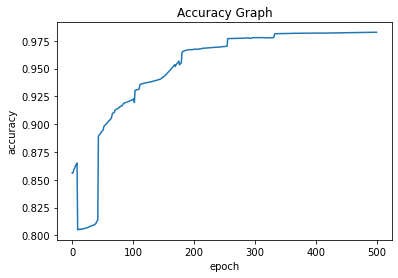

In [11]:
#plot Accuracy Graph
plt.plot(accuracy_history)
plt.title("Accuracy Graph")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()




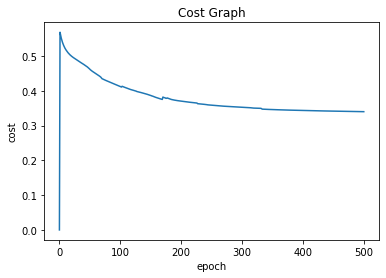

In [12]:
#plot Cost Graph
plt.plot(cost_history)
plt.title("Cost Graph")
plt.xlabel("epoch")
plt.ylabel("cost")
plt.show()


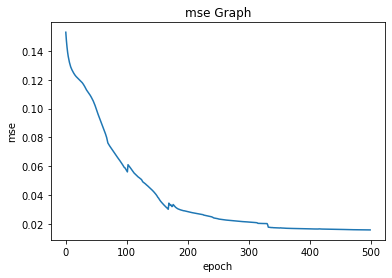

In [13]:
#plot mse Graph
plt.plot(mse_history)
plt.title("mse Graph")
plt.xlabel("epoch")
plt.ylabel("mse")
plt.show()

In [14]:
#print final accuracy

correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print ("test accuracy: ", (sess.run(accuracy, feed_dict={x: test_x, y_: test_y})))
            
                              


test accuracy:  0.9826323


In [15]:
#print the final mean sq error
pred_y = sess.run(y, feed_dict={x:test_x})
mse = tf.reduce_mean(tf.square(pred_y) - test_y)                              
print ("Mse: %.4f" % sess.run(mse)) 

Mse: -0.0206


In [16]:
pred_y

array([[0.01264326, 0.9873568 ],
       [0.01410539, 0.9858946 ],
       [0.9511589 , 0.0488411 ],
       ...,
       [0.01264326, 0.9873568 ],
       [0.01410538, 0.9858947 ],
       [0.01264326, 0.9873568 ]], dtype=float32)

In [17]:
test_x

array([[0., 2., 9., ..., 0., 0., 1.],
       [0., 2., 9., ..., 0., 0., 1.],
       [1., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 2., 9., ..., 0., 0., 1.],
       [0., 2., 9., ..., 0., 0., 1.],
       [0., 2., 9., ..., 0., 0., 1.]])

In [18]:

# Create a summary writer
writer = tf.summary.FileWriter("logs/", graph=tf.get_default_graph())
writer.close()

In [19]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


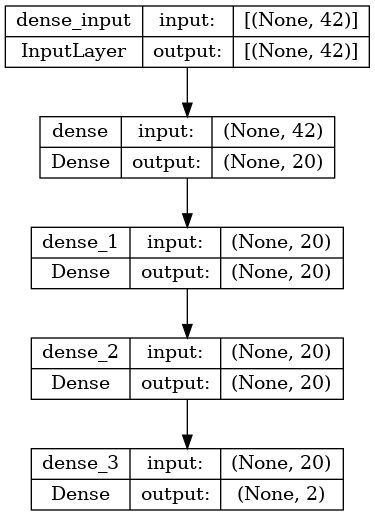

In [20]:
# Define the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(n_hidden_1, activation='relu', input_shape=(n_dim,)))
model.add(tf.keras.layers.Dense(n_hidden_2, activation='sigmoid'))
model.add(tf.keras.layers.Dense(n_hidden_3, activation='softmax'))
model.add(tf.keras.layers.Dense(n_class, activation='softmax'))

# Save the model to a file
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


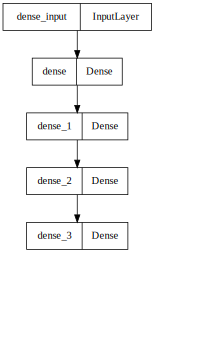

In [21]:
# Display the model image
SVG(model_to_dot(model).create(prog='dot', format='svg'))